<h2>Solar Power Generation Forecasting</h2>

<h3>Importing Libraries And Dataset</h3>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

dts = pd.read_csv('solarpowergeneration.csv')
dts.head(10)

,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,31,1035.0,0.0,0.0,0.0,0,0,0,0.00,...,312.71,9.36,22.62,6.62,337.62,24.48,58.753108,83.237322,128.33543,454.100950
1,2.31,27,1035.1,0.0,0.0,0.0,0,0,0,1.78,...,294.78,5.99,32.74,4.61,321.34,21.96,45.408585,75.143041,139.65530,1411.999400
2,3.65,33,1035.4,0.0,0.0,0.0,0,0,0,108.58,...,270.00,3.89,56.31,3.76,286.70,14.04,32.848282,68.820648,152.53769,2214.849300
3,5.82,30,1035.4,0.0,0.0,0.0,0,0,0,258.10,...,323.13,3.55,23.96,3.08,339.44,19.80,22.699288,64.883536,166.90159,2527.609200
4,7.73,27,1034.4,0.0,0.0,0.0,0,0,0,375.58,...,10.01,6.76,25.20,6.62,22.38,16.56,19.199908,63.795208,182.13526,2640.203400
5,8.69,29,1034.6,0.0,0.0,0.0,0,0,0,449.45,...,23.63,7.10,30.47,6.92,27.90,17.28,25.088167,65.700860,197.22062,2546.081600
6,9.72,27,1034.0,0.0,0.0,0.0,0,0,0,469.92,...,25.02,6.61,29.36,6.44,26.57,12.96,36.197514,70.351498,211.21422,2270.320700
7,10.07,28,1034.1,0.0,0.0,0.0,0,0,0,436.99,...,14.74,7.63,19.29,7.52,16.70,10.80,49.073008,77.228779,223.65641,1063.830200
8,9.38,32,1033.9,0.0,0.0,0.0,0,0,0,353.33,...,6.58,10.50,5.91,10.14,6.12,11.52,62.371140,85.585411,234.50308,86.817611
9,6.54,47,1035.1,0.0,0.0,0.0,0,0,0,228.73,...,360.00,12.25,1.68,11.53,1.79,12.24,105.866560,121.463180,216.06756,9.666667


In [3]:
X = dts.iloc[:, :-1].values
y = dts.iloc[:, -1].values
print(X.shape, y.shape)
y = np.reshape(y, (-1,1))
y.shape

(4213, 20) (4213,)


(4213, 1)

In [4]:
X

array([[   2.17    ,   31.      , 1035.      , ...,   58.753108,
          83.237322,  128.33543 ],
       [   2.31    ,   27.      , 1035.1     , ...,   45.408585,
          75.143041,  139.6553  ],
       [   3.65    ,   33.      , 1035.4     , ...,   32.848282,
          68.820648,  152.53769 ],
       ...,
       [   7.27    ,   90.      , 1026.3     , ...,   25.249506,
          65.827032,  197.33868 ],
       [   8.25    ,   81.      , 1025.5     , ...,   36.361161,
          70.496313,  211.30027 ],
       [   8.      ,   80.      , 1025.3     , ...,   48.452849,
          76.919574,  223.04931 ]])

In [5]:
y

array([[ 454.10095 ],
       [1411.9994  ],
       [2214.8493  ],
       ...,
       [ 158.36778 ],
       [ 126.95306 ],
       [  20.055031]])

<h3>Splitting Training and Test sets</h3>

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Shape: {} {} \nTest Shape: {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train Shape: (3159, 20) (3159, 1) 
Test Shape: (1054, 20) (1054, 1)


<h3>Feature Scaling</h3>

In [7]:
from sklearn.preprocessing import StandardScaler
# input scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# outcome scaling:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)    
y_test = sc_y.transform(y_test)

In [8]:
X_train

array([[-0.15688663, -0.65066193,  0.32458773, ..., -1.17016507,
         0.20906612,  0.23973116],
       [-0.96299273,  1.26236489, -0.09488224, ...,  0.21285162,
         1.10270022, -0.59126299],
       [-0.01104135, -0.22554486, -1.44007902, ..., -0.78166945,
        -1.98808451, -0.32872643],
       ...,
       [ 0.08053592, -0.39559169, -0.65899702, ..., -1.39867408,
        -1.07235309, -0.0910784 ],
       [ 0.34283131, -0.90573217,  0.59941288, ..., -0.46582577,
         0.41541699,  0.76311909],
       [-0.6893915 ,  0.62468928,  1.45281728, ...,  0.28508139,
         0.20437129, -0.90996355]])

In [9]:
X_test

array([[ 0.34735364, -1.37336095,  0.58494839, ..., -0.78124559,
        -0.35197112,  0.78338018],
       [-1.93190285,  1.68748196, -0.84703527, ...,  0.34119265,
         1.11388012, -0.66875224],
       [-0.95055631,  0.28459563,  0.97548939, ...,  0.32973403,
        -0.38653881, -1.09819031],
       ...,
       [ 0.69783455, -1.37336095,  1.09120525, ..., -0.47407508,
         0.36095606,  0.77638555],
       [-0.00991077, -1.6709429 ,  1.93014517, ..., -1.21521633,
         0.12748879,  0.27526625],
       [-0.58537781,  1.00729465, -1.0640025 , ...,  0.07094803,
         0.619908  , -0.66549089]])

In [10]:
y_train

array([[ 0.37304328],
       [-0.96068338],
       [ 0.56242648],
       ...,
       [ 1.74385844],
       [-0.58299753],
       [-0.14116491]])

<h3>Creating Neural Network</h3>

In [11]:
def create_spfnet(n_layers, n_activation, kernels):
  model = tf.keras.models.Sequential()
  for i, nodes in enumerate(n_layers):
    if i==0:
      model.add(Dense(nodes, kernel_initializer=kernels, activation=n_activation, input_dim=X_train.shape[1]))
      #model.add(Dropout(0.3))
    else:
      model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
      #model.add(Dropout(0.3))
  
  model.add(Dense(1))
  model.compile(loss='mse', 
                optimizer='adam',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

In [14]:
spfnet = create_spfnet([32, 64], 'relu', 'normal')
spfnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 32)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,849 (11.13 KB)

 Trainable params: 2,849 (11.13 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(spfnet, to_file='spfnet_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [17]:
hist = spfnet.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test),epochs=150, verbose=2)

Epoch 1/150
99/99 - 1s - 8ms/step - loss: 0.0748 - root_mean_squared_error: 0.2734 - val_loss: 0.2584 - val_root_mean_squared_error: 0.5083
Epoch 2/150
99/99 - 1s - 7ms/step - loss: 0.0751 - root_mean_squared_error: 0.2740 - val_loss: 0.2476 - val_root_mean_squared_error: 0.4976
Epoch 3/150
99/99 - 1s - 8ms/step - loss: 0.0760 - root_mean_squared_error: 0.2756 - val_loss: 0.2660 - val_root_mean_squared_error: 0.5157
Epoch 4/150
99/99 - 1s - 8ms/step - loss: 0.0766 - root_mean_squared_error: 0.2767 - val_loss: 0.2577 - val_root_mean_squared_error: 0.5077
Epoch 5/150
99/99 - 1s - 8ms/step - loss: 0.0743 - root_mean_squared_error: 0.2725 - val_loss: 0.2488 - val_root_mean_squared_error: 0.4988
Epoch 6/150
99/99 - 1s - 13ms/step - loss: 0.0737 - root_mean_squared_error: 0.2716 - val_loss: 0.2604 - val_root_mean_squared_error: 0.5103
Epoch 7/150
99/99 - 1s - 6ms/step - loss: 0.0762 - root_mean_squared_error: 0.2761 - val_loss: 0.2534 - val_root_mean_squared_error: 0.5034
Epoch 8/150
99/99 -

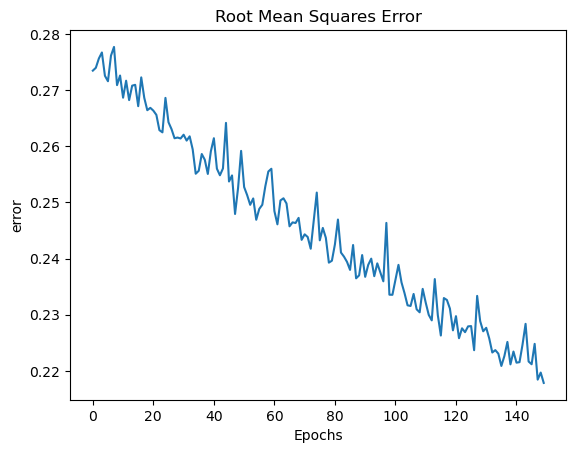

In [30]:
plt.plot(hist.history['root_mean_squared_error'])
#plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Root Mean Squares Error')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.show()

In [31]:
spfnet.evaluate(X_train, y_train)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0471 - root_mean_squared_error: 0.2168


[0.04618864133954048, 0.2149154245853424]

In [32]:
from sklearn.metrics import mean_squared_error

y_pred = spfnet.predict(X_test) # get model predictions (scaled inputs here)
y_pred_orig = sc_y.inverse_transform(y_pred) # unscale the predictions
y_test_orig = sc_y.inverse_transform(y_test) # unscale the true test outcomes

RMSE_orig = mean_squared_error(y_pred_orig, y_test_orig, squared=False)
RMSE_orig

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


498.44046474941524

In [33]:
train_pred = spfnet.predict(X_train) # get model predictions (scaled inputs here)
train_pred_orig = sc_y.inverse_transform(train_pred) # unscale the predictions
y_train_orig = sc_y.inverse_transform(y_train) # unscale the true train outcomes

mean_squared_error(train_pred_orig, y_train_orig, squared=False)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


200.94233545170374

In [34]:
from sklearn.metrics import r2_score
r2_score(y_pred_orig, y_test_orig)

0.7135002183565166

In [35]:
r2_score(train_pred_orig, y_train_orig)

0.9509962505842394

In [36]:
np.concatenate((train_pred_orig, y_train_orig), 1)

array([[1231.89367676, 1485.1517    ],
       [ 380.0506897 ,  238.13972   ],
       [1905.47595215, 1662.2218    ],
       ...,
       [2906.70996094, 2766.8408    ],
       [ 602.57177734,  591.26963   ],
       [1427.65759277, 1004.3757    ]])

In [38]:
np.concatenate((y_pred_orig, y_test_orig), 1)

array([[2669.64599609, 2511.2375    ],
       [ 633.18225098,  480.20512   ],
       [2186.27124023, 2017.5687    ],
       ...,
       [ 726.63739014,  523.50056   ],
       [2470.89526367, 2506.2019    ],
       [ 916.08953857,  484.93113   ]])

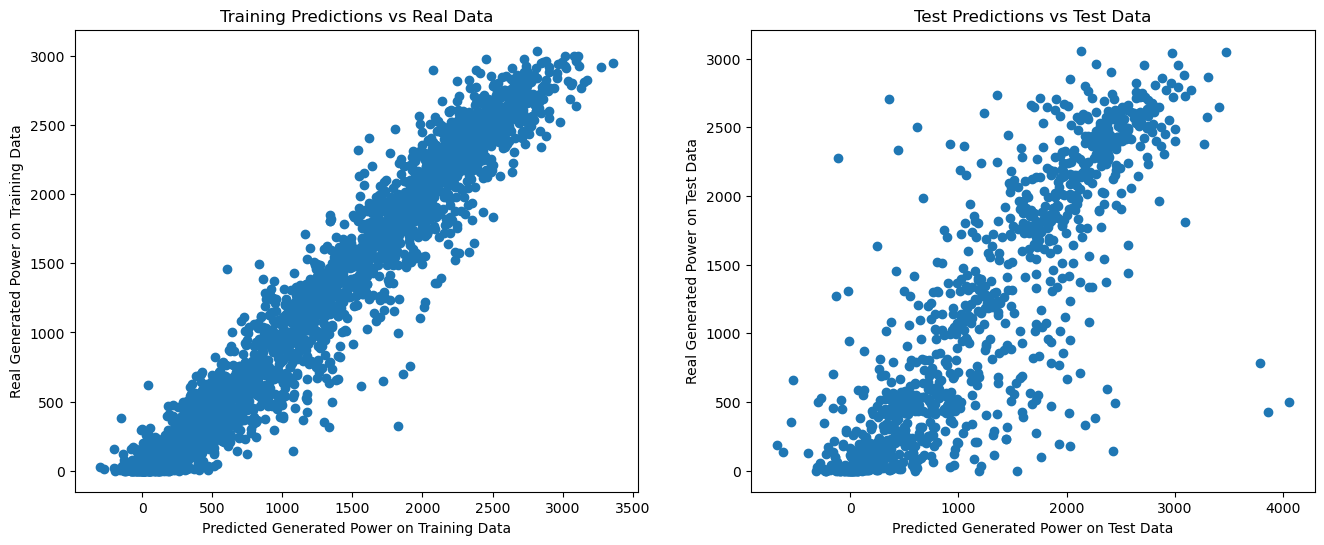

In [39]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
plt.scatter(y_pred_orig, y_test_orig)
plt.xlabel('Predicted Generated Power on Test Data')
plt.ylabel('Real Generated Power on Test Data')
plt.title('Test Predictions vs Test Data')
#plt.scatter(y_test_orig, sc_X.inverse_transform(X_test)[:,2], color='green')
plt.subplot(1,2,1)
plt.scatter(train_pred_orig, y_train_orig)
plt.xlabel('Predicted Generated Power on Training Data')
plt.ylabel('Real Generated Power on Training Data')
plt.title('Training Predictions vs Real Data')
plt.show()

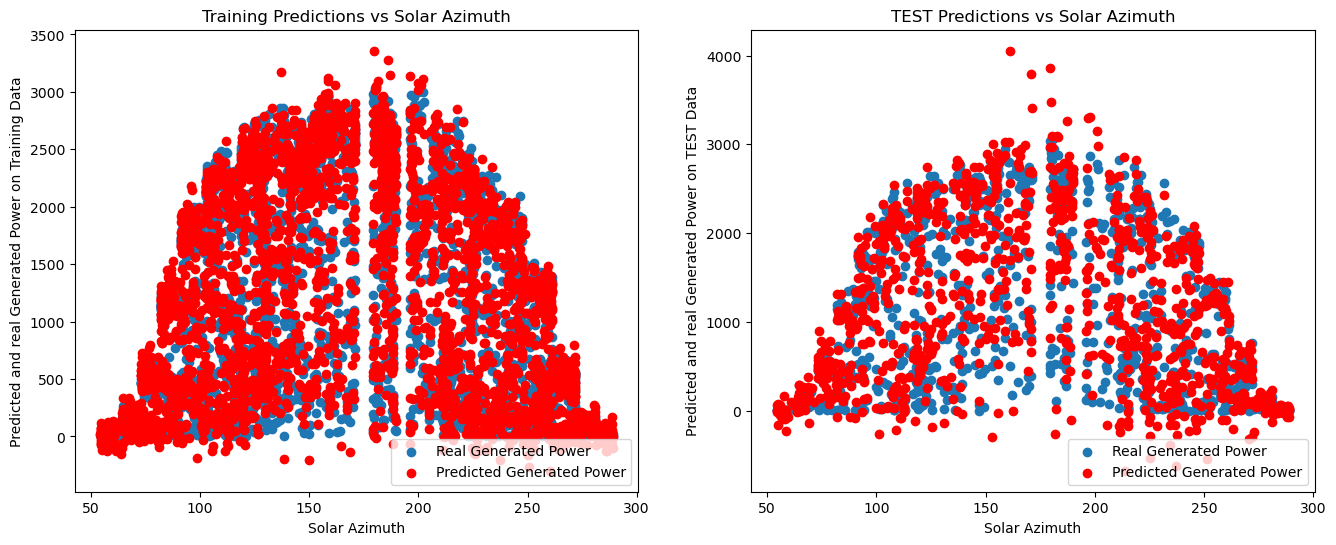

In [40]:
x_axis = sc_X.inverse_transform(X_train)[:,-1]
x2_axis = sc_X.inverse_transform(X_test)[:,-1]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x_axis, y_train_orig, label='Real Generated Power')
plt.scatter(x_axis, train_pred_orig, c='red', label='Predicted Generated Power')
plt.ylabel('Predicted and real Generated Power on Training Data')
plt.xlabel('Solar Azimuth')
plt.title('Training Predictions vs Solar Azimuth')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.scatter(x2_axis, y_test_orig, label='Real Generated Power')
plt.scatter(x2_axis, y_pred_orig, c='red', label='Predicted Generated Power')
plt.ylabel('Predicted and real Generated Power on TEST Data')
plt.xlabel('Solar Azimuth')
plt.title('TEST Predictions vs Solar Azimuth')
plt.legend(loc='lower right')
plt.show()

In [41]:
results = np.concatenate((y_test_orig, y_pred_orig), 1)
results = pd.DataFrame(data=results)
results.columns = ['Real Solar Power Produced', 'Predicted Solar Power']
#results = results.sort_values(by=['Real Solar Power Produced'])
pd.options.display.float_format = "{:,.2f}".format
#results[800:820]
results[7:18]

,Real Solar Power Produced,Predicted Solar Power
7,"2,497.53","2,746.12"
8,514.65,556.80
9,916.92,"1,451.90"
10,"1,911.95","1,623.71"
11,35.15,610.72
12,"2,449.04","2,905.76"
13,38.84,957.92
14,823.41,"1,685.43"
15,"2,274.65","2,249.71"
16,"1,123.40","1,093.35"


In [42]:
sc = StandardScaler()
pred_whole = spfnet.predict(sc.fit_transform(X))
pred_whole_orig = sc_y.inverse_transform(pred_whole)
pred_whole_orig

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[ 719.1663 ],
       [1541.5059 ],
       [2216.3494 ],
       ...,
       [ 970.8471 ],
       [ 302.77603],
       [ 440.80325]], dtype=float32)

In [43]:
y

array([[ 454.10095 ],
       [1411.9994  ],
       [2214.8493  ],
       ...,
       [ 158.36778 ],
       [ 126.95306 ],
       [  20.055031]])

In [44]:
r2_score(pred_whole_orig, y)

0.887561954328168

In [46]:
df_results = pd.DataFrame.from_dict({
    'R2 Score of Whole Data Frame': r2_score(pred_whole_orig, y),
    'R2 Score of Training Set': r2_score(train_pred_orig, y_train_orig),
    'R2 Score of Test Set': r2_score(y_pred_orig, y_test_orig),
    'Mean of Test Set': np.mean(y_pred_orig),
    'Standard Deviation pf Test Set': np.std(y_pred_orig),
    'Relative Standard Deviation': np.std(y_pred_orig) / np.mean(y_pred_orig),
},orient='index', columns=['Value'])
display(df_results.style.background_gradient(cmap='afmhot', axis=0))

,Value
R2 Score of Whole Data Frame,0.887562
R2 Score of Training Set,0.950996
R2 Score of Test Set,0.713500
Mean of Test Set,1194.367310
Standard Deviation pf Test Set,931.217529
Relative Standard Deviation,0.779674


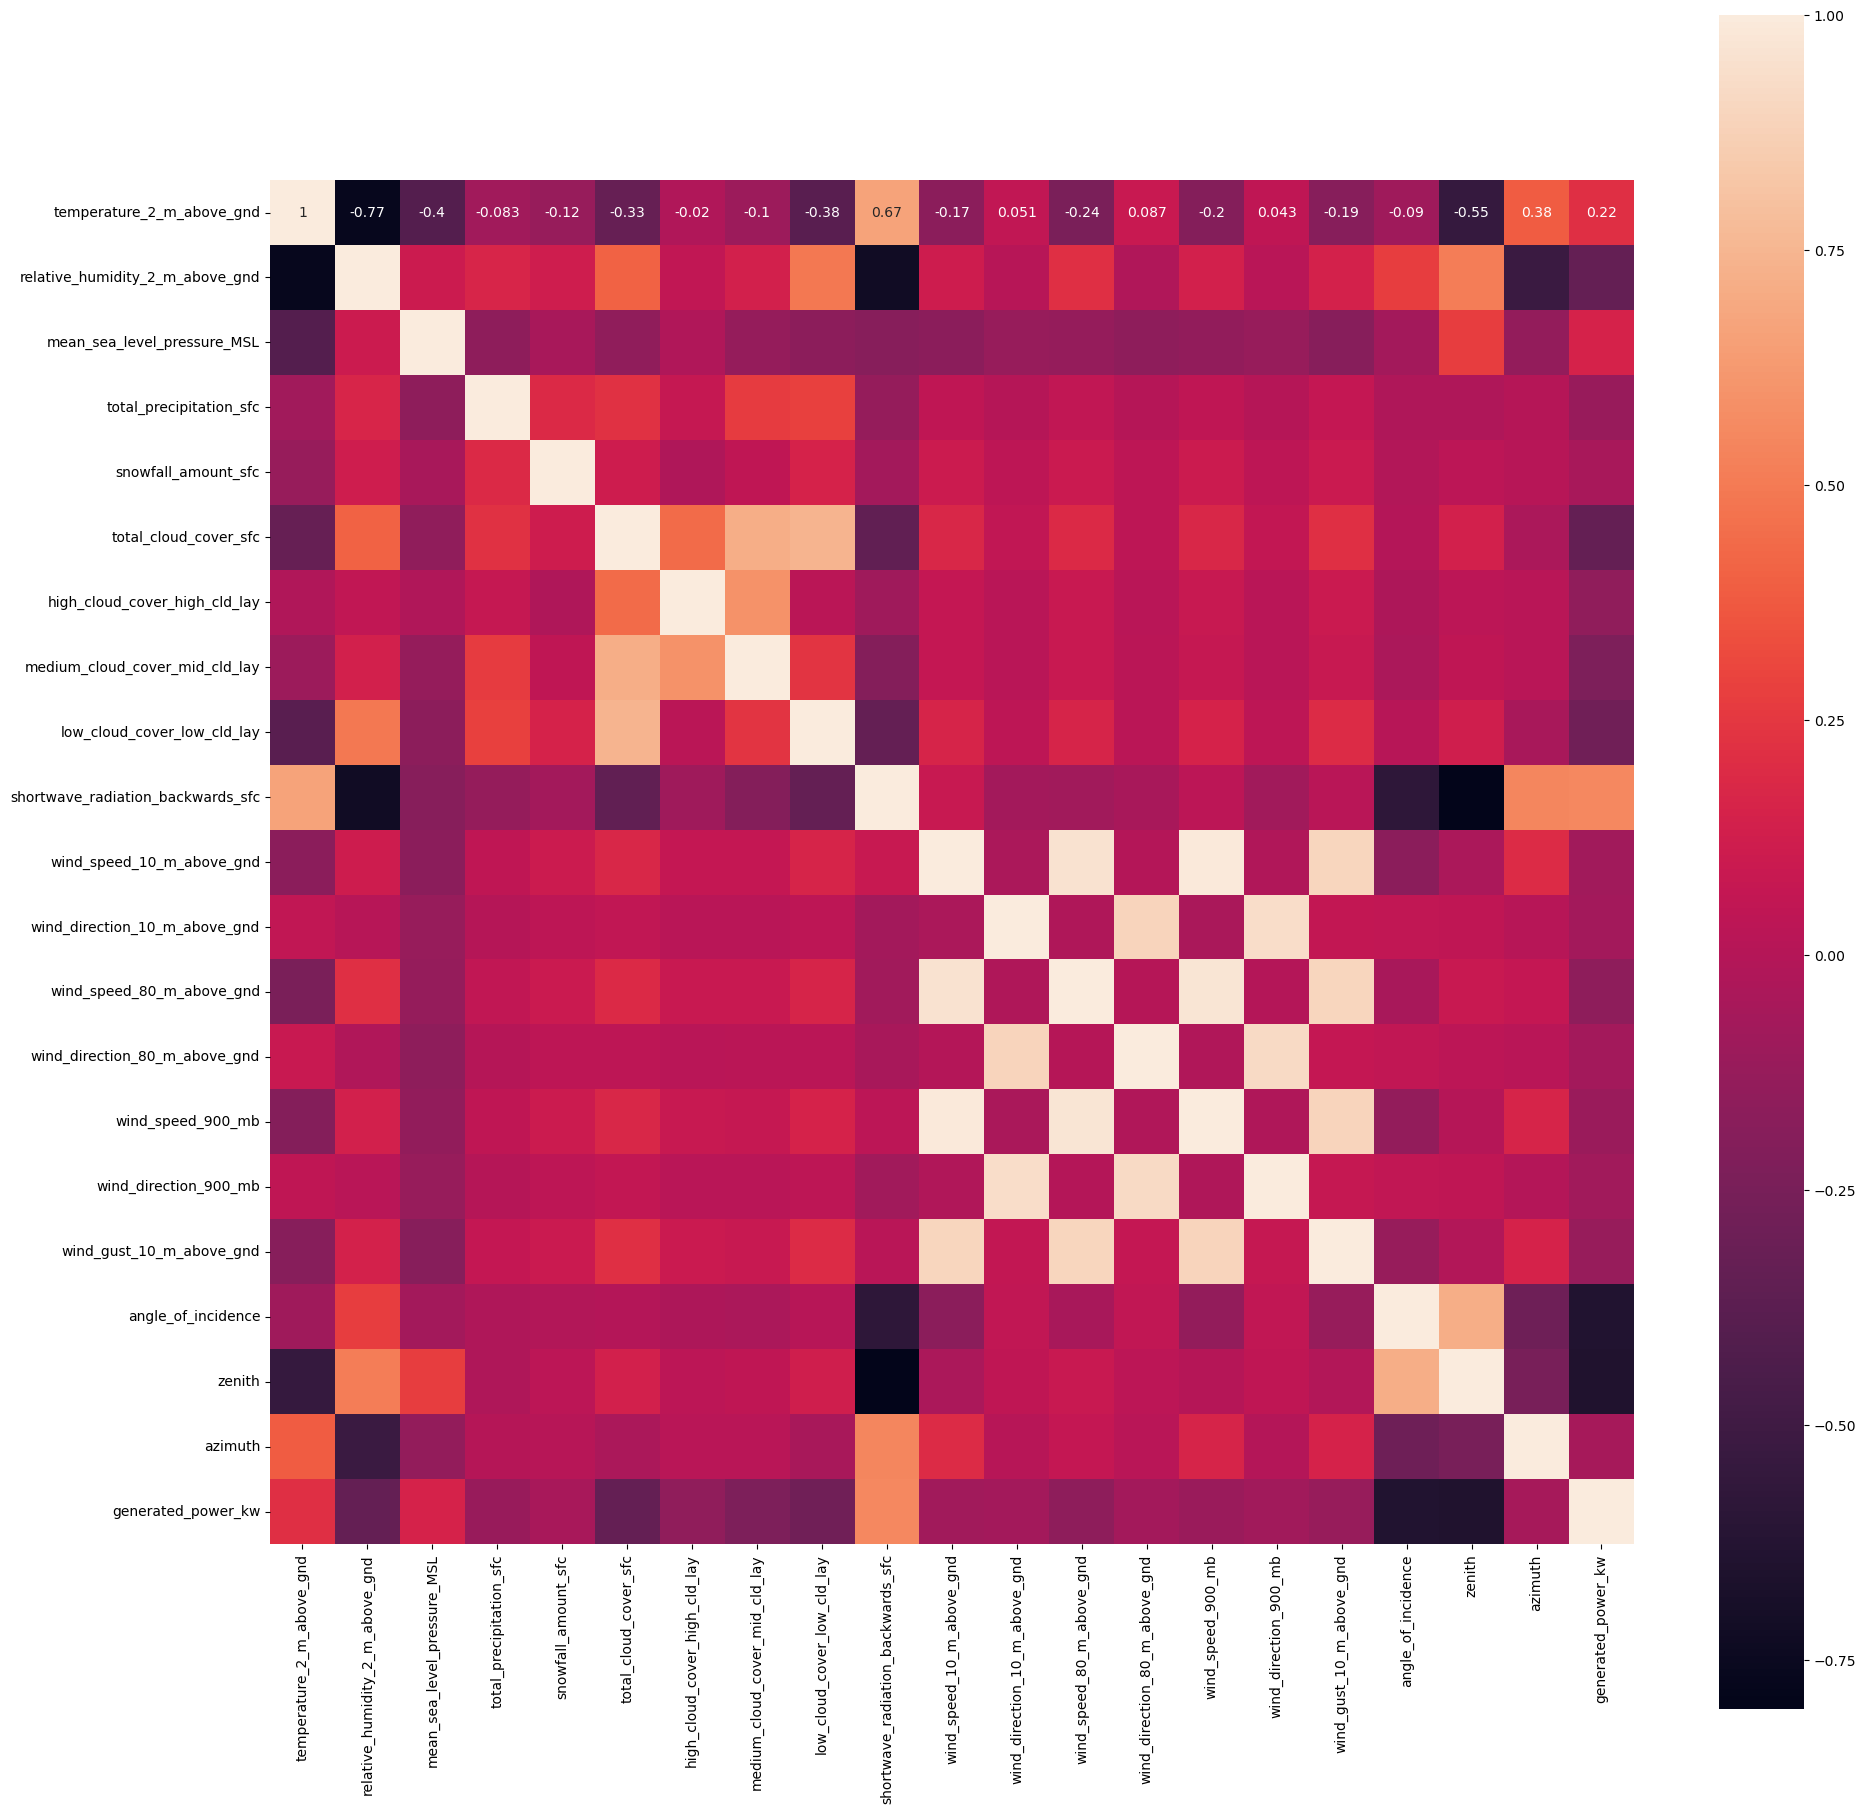

In [47]:
corr = dts.corr()
plt.figure(figsize=(22,22))
sns.heatmap(corr, annot=True, square=True);

In [49]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=dts.columns[:-1])
lasso_coeff.sort_values('Feature Importance', ascending=False)

,Feature Importance
shortwave_radiation_backwards_sfc,0.38
mean_sea_level_pressure_MSL,0.12
wind_speed_80_m_above_gnd,0.07
wind_speed_10_m_above_gnd,0.02
snowfall_amount_sfc,0.02
wind_direction_80_m_above_gnd,0.01
wind_direction_10_m_above_gnd,0.01
wind_direction_900_mb,-0.00
total_precipitation_sfc,-0.00
wind_gust_10_m_above_gnd,-0.03


<h3>OBSERVATIONS</h3>
     <ul>-> High Correlation between Zenith and Agnle of Incidence of 0.71</ul>
     <ul>-> Shortwave radiation backwards and Generate Power KW has corr of 0.56</ul>
     <ul>-> Relative Humidity and Zenith are +ve corr (0.51)</ul>
     <ul>-> Relative Humidity and Low Cloud Cover are + ve correlated (0.49)</ul>
     <ul>-> Angle of Incidence and Zenith are -vely correlated with Genarted Power (-0.65)</ul>
     <ul>-> -ve corr between Zenith and temperature of -0.55</ul>
     <ul>-> High negative corr exists btw Shortwave radiation backwards and Zenith (-.8)</ul>
     <ul>-> Shortwave radiation backwards and Relative humidity are -vely correlated (-.72)</ul>
     <ul>-> Relative humidity and Temperature are -vely correlated (-.77)</ul>

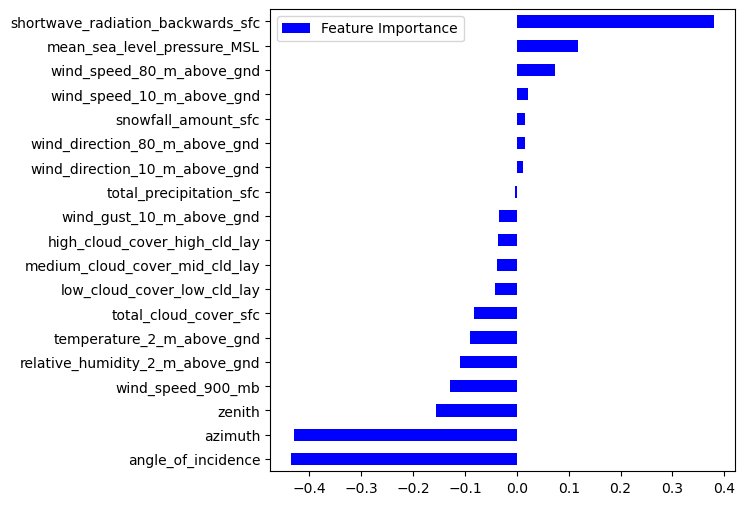

In [50]:
g = lasso_coeff[lasso_coeff['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(6,6), cmap='winter')